# Deep Crossentropy method

In this section we'll extend your CEM implementation with neural networks! You will train a multi-layer neural network to solve simple continuous state space games. __Please make sure you're done with tabular crossentropy method from the previous notebook.__

![img](https://watanimg.elwatannews.com/old_news_images/large/249765_Large_20140709045740_11.jpg)



In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

/bin/bash: ../xvfb: No such file or directory


In [2]:
!pip install gymnasium[toy_text,classic_control]

G:\Program Files\conda\lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


state vector dim = 4
n_actions = 2


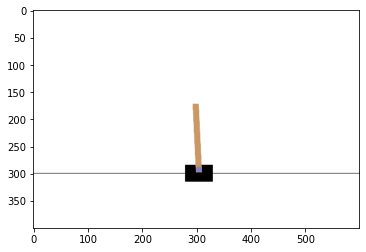

In [3]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("CartPole-v0", render_mode="rgb_array").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render())
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

env.close()

# Neural Network Policy

For this assignment we'll utilize the simplified neural network implementation from __[Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)__. Here's what you'll need:

* `agent.partial_fit(states, actions)` - make a single training pass over the data. Maximize the probability of :actions: from :states:
* `agent.predict_proba(states)` - predict probabilities of all actions, a matrix of shape __[len(states), n_actions]__


In [4]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation="tanh",
)

# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()[0]] * n_actions, range(n_actions), range(n_actions))


MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20))

In [5]:
def generate_session(env,agent,t_max=1000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0

    s,_= env.reset()

    for t in range(t_max):

        # use agent to predict a vector of action probabilities for state :s:
        probs = agent.predict_proba([s])[0]

        assert probs.shape == (env.action_space.n,), "make sure probabilities are a vector (hint: np.reshape)"

        # use the probabilities you predicted to pick an action
        # sample proportionally to the probabilities, don't just take the most likely action
        a = np.random.choice(list(range(n_actions)),p=probs)
        # ^-- hint: try np.random.choice

        new_s, r, terminated, truncated, _ = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if terminated or truncated:
            break
    return states, actions, total_reward

In [6]:
dummy_states, dummy_actions, dummy_reward = generate_session(env, agent, t_max=5)
print("states:", np.stack(dummy_states))
print("actions:", dummy_actions)
print("reward:", dummy_reward)


states: [[ 0.04059971  0.00923712  0.03723666 -0.00242235]
 [ 0.04078446  0.2038058   0.03718821 -0.28312802]
 [ 0.04486057  0.00817371  0.03152565  0.02104805]
 [ 0.04502404 -0.18738584  0.03194661  0.32350862]
 [ 0.04127633 -0.38294777  0.03841678  0.62609255]]
actions: [1, 0, 0, 0, 1]
reward: 5.0


### CEM steps
Deep CEM uses exactly the same strategy as the regular CEM, so you can copy your function code from previous notebook.

The only difference is that now each observation is not a number but a `float32` vector.

In [7]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """
    reward_threshold = np.percentile(rewards_batch,percentile)
    elite_states = []
    elite_actions = []


    for i in range(len(states_batch)):
      if rewards_batch[i]>=reward_threshold:
          elite_states.extend(states_batch[i])
          elite_actions.extend(actions_batch[i])

    return elite_states, elite_actions


In [8]:
states_batch = [
    [1, 2, 3],     # game1
    [4, 2, 0, 2],  # game2
    [3, 1],        # game3
]

actions_batch = [
    [0, 2, 4],     # game1
    [3, 2, 0, 1],  # game2
    [3, 3],        # game3
]
rewards_batch = [
    3,  # game1
    4,  # game2
    5,  # game3
]

test_result_0 = select_elites(states_batch, actions_batch, rewards_batch, percentile=0)
test_result_30 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=30
)
test_result_90 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=90
)
test_result_100 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=100
)

assert np.all(test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1]) and np.all(
    test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]
), "For percentile 0 you should return all states and actions in chronological order"
assert np.all(test_result_30[0] == [4, 2, 0, 2, 3, 1]) and np.all(
    test_result_30[1] == [3, 2, 0, 1, 3, 3]
), "For percentile 30 you should only select states/actions from two first"
assert np.all(test_result_90[0] == [3, 1]) and np.all(
    test_result_90[1] == [3, 3]
), "For percentile 90 you should only select states/actions from one game"
assert np.all(test_result_100[0] == [3, 1]) and np.all(
    test_result_100[1] == [3, 3]
), "Please make sure you use >=, not >. Also double-check how you compute percentile."

print("Ok!")

Ok!


# Training loop
Generate sessions, select N best and fit to those.

In [9]:
from IPython.display import clear_output


def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress.
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label="Mean rewards")
    plt.plot(list(zip(*log))[1], label="Reward thresholds")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines(
        [np.percentile(rewards_batch, percentile)],
        [0],
        [100],
        label="percentile",
        color="red",
    )
    plt.legend()
    plt.grid()

    plt.show()


mean reward = 463.440, threshold=494.400


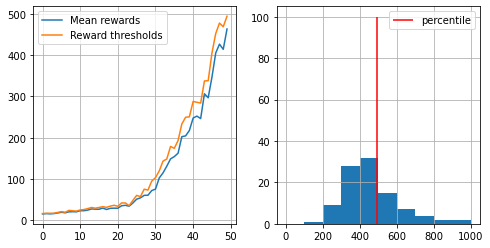

You Win! You may stop training now via KeyboardInterrupt.


KeyboardInterrupt: 

In [10]:
n_sessions = 100
percentile = 70
log = []

#print(f"{states_batch}\n{actions_batch}\n{rewards_batch}")
for i in range(100):
    # generate new sessions
    sessions = [generate_session(env, agent) for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    agent.partial_fit(elite_states, elite_actions)

    show_progress(
        rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)]
    )

    if np.mean(rewards_batch) > 190:

        print("You Win! You may stop training now via KeyboardInterrupt.")


mean reward = 970.285, threshold=1000.000


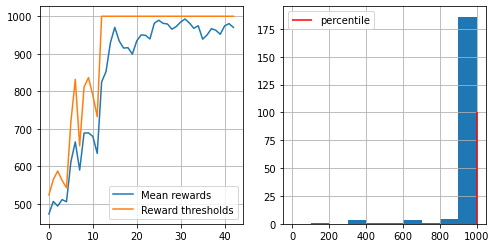

You Win! You may stop training now via KeyboardInterrupt.


KeyboardInterrupt: 

In [11]:
n_sessions = 200
percentile = 70
log = []

#print(f"{states_batch}\n{actions_batch}\n{rewards_batch}")
for i in range(100):
    # generate new sessions
    sessions = [generate_session(env, agent) for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    agent.partial_fit(elite_states, elite_actions)

    show_progress(
        rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)]
    )

    if np.mean(rewards_batch) > 190:

        print("You Win! You may stop training now via KeyboardInterrupt.")

mean reward = 975.860, threshold=1000.000


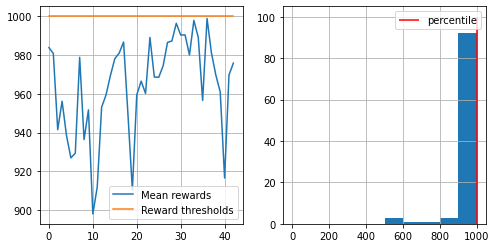

You Win! You may stop training now via KeyboardInterrupt.


KeyboardInterrupt: 

In [12]:
n_sessions = 100
percentile = 30
log = []

#print(f"{states_batch}\n{actions_batch}\n{rewards_batch}")
for i in range(100):
    # generate new sessions
    sessions = [generate_session(env, agent) for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    agent.partial_fit(elite_states, elite_actions)

    show_progress(
        rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)]
    )

    if np.mean(rewards_batch) > 190:

        print("You Win! You may stop training now via KeyboardInterrupt.")

mean reward = 960.790, threshold=1000.000


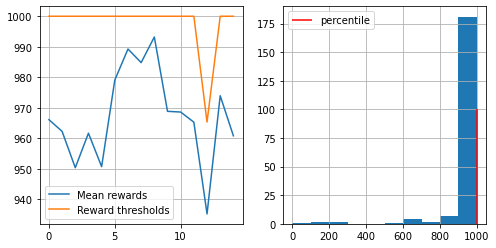

You Win! You may stop training now via KeyboardInterrupt.


KeyboardInterrupt: 

In [13]:
n_sessions = 200
percentile = 30
log = []

#print(f"{states_batch}\n{actions_batch}\n{rewards_batch}")
for i in range(100):
    # generate new sessions
    sessions = [generate_session(env, agent) for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    agent.partial_fit(elite_states, elite_actions)

    show_progress(
        rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)]
    )

    if np.mean(rewards_batch) > 190:

        print("You Win! You may stop training now via KeyboardInterrupt.")

# Results

In [ ]:
pip install moviepy

In [11]:
# Record sessions

from gymnasium.wrappers import RecordVideo

with RecordVideo(
    env=gym.make("CartPole-v0", render_mode="rgb_array"),
    video_folder="./videos1",
    episode_trigger=lambda episode_number: True,
) as env_monitor:
    sessions = [generate_session(env_monitor, agent) for _ in range(100)]


G:\Program Files\conda\lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
G:\Program Files\conda\lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at C:\Users\dobry\videos1 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-0.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-0.mp4
Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-1.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-1.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-2.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-2.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-3.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-3.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-4.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-4.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-5.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-5.mp4
Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-6.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-6.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-7.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-7.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-8.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-8.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-9.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-9.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-10.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-10.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-10.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-11.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-11.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-11.mp4
Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-12.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-12.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-12.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-13.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-13.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-13.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-14.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-14.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-14.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-15.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-15.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-15.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-16.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-16.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-16.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-17.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-17.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-17.mp4
Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-18.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-18.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-18.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-19.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-19.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-19.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-20.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-20.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-20.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-21.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-21.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-21.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-22.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-22.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-22.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-23.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-23.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-23.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-24.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-24.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-24.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-25.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-25.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-25.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-26.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-26.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-26.mp4
Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-27.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-27.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-27.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-28.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-28.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-28.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-29.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-29.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-29.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-30.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-30.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-30.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-31.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-31.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-31.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-32.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-32.mp4



Moviepy - Done !


Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-32.mp4
Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-33.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-33.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-33.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-34.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-34.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-34.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-35.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-35.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-35.mp4
Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-36.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-36.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-36.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-37.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-37.mp4



Moviepy - Done !


Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-37.mp4
Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-38.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-38.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-38.mp4
Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-39.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-39.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-39.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-40.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-40.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-40.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-41.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-41.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-41.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-42.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-42.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-42.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-43.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-43.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-43.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-44.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-44.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-44.mp4
Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-45.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-45.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-45.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-46.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-46.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-46.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-47.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-47.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-47.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-48.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-48.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-48.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-49.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-49.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-49.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-50.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-50.mp4



Moviepy - Done !


Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-50.mp4
Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-51.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-51.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-51.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-52.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-52.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-52.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-53.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-53.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-53.mp4
Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-54.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-54.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-54.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-55.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-55.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-55.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-56.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-56.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-56.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-57.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-57.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-57.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-58.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-58.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-58.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-59.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-59.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-59.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-60.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-60.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-60.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-61.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-61.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-61.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-62.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-62.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-62.mp4
Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-63.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-63.mp4



Moviepy - Done !


Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-63.mp4
Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-64.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-64.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-64.mp4
Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-65.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-65.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-65.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-66.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-66.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-66.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-67.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-67.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-67.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-68.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-68.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-68.mp4
Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-69.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-69.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-69.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-70.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-70.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-70.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-71.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-71.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-71.mp4
Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-72.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-72.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-72.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-73.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-73.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-73.mp4
Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-74.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-74.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-74.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-75.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-75.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-75.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-76.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-76.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-76.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-77.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-77.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-77.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-78.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-78.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-78.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-79.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-79.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-79.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-80.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-80.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-80.mp4
Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-81.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-81.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-81.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-82.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-82.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-82.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-83.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-83.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-83.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-84.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-84.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-84.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-85.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-85.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-85.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-86.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-86.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-86.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-87.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-87.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-87.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-88.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-88.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-88.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-89.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-89.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-89.mp4
Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-90.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-90.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-90.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-91.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-91.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-91.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-92.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-92.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-92.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-93.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-93.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-93.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-94.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-94.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-94.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-95.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-95.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-95.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-96.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-96.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-96.mp4
Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-97.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-97.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-97.mp4


Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-98.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-98.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-98.mp4
Moviepy - Building video C:\Users\dobry\videos1\rl-video-episode-99.mp4.
Moviepy - Writing video C:\Users\dobry\videos1\rl-video-episode-99.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\dobry\videos1\rl-video-episode-99.mp4


In [13]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

video_paths = sorted([s for s in Path("videos1").iterdir() if s.suffix == ".mp4"])
video_path = video_paths[-1]  # You can also try other indices

if "google.colab" in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open("rb") as fp:
        mp4 = fp.read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)
